Tutorial 2 - https://medium.datadriveninvestor.com/using-machine-learning-for-time-series-forecasting-db94e523d42a

In [1]:
#pip install lightgbm

In [2]:
import time    # To time our operations
import numpy as np  # linear algebra
import pandas as pd     # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt        # To visualize
import seaborn as sns       # To visualize
import lightgbm as lgb      # To train our model
import warnings     # To ignore some warnings that we don't care
warnings.filterwarnings('ignore')   
pd.set_option('display.max_columns', None)  # Unlimited columns
pd.set_option('display.width', 500)     # Width of the display in the notebook

In [3]:
train = pd.read_csv('../Data/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])    # parse_dates: Converts the date column to datetime format.
test = pd.read_csv('../Data/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
sample_sub = pd.read_csv('../Data/demand-forecasting-kernels-only/sample_submission.csv')

In [4]:
df = pd.concat([train, test], sort=False)

In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [6]:
df["date"].min(), df["date"].max()            # First and last dates in the dataset

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [7]:
check_df(df)

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

In [8]:
df[["store"]].nunique()      # Number of stores

store    10
dtype: int64

In [9]:
df[["item"]].nunique()       # Number of products

item    50
dtype: int64

In [10]:
df.groupby(["store"])["item"].nunique()    # Number of products in store breakdown

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [11]:
df.groupby(["store", "item"]).agg({"sales": ["sum"]})     # Total sales in store and product breakdown

sales
                 sum
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

In [12]:
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})          # Total sales, average sales, median sales and standard deviation in store and product breakdown

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [13]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

df = create_date_features(df)

In [14]:
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

In [15]:
#pip install autoviz

In [16]:
# from autoviz.AutoViz_Class import AutoViz_Class
# AV = AutoViz_Class()

# %matplotlib inline 
# # Generate visualizations
# AV.AutoViz("/kaggle/input/demand-forecasting-kernels-only/test.csv")

In [17]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [18]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

pd.DataFrame({"sales": df["sales"].values[0:10],    # first 10 values in sales column
              "lag1": df["sales"].shift(1).values[0:10],    # The previous values of the first 10 values in the sales column
              "lag2": df["sales"].shift(2).values[0:10],    # The two previous values of the first 10 values in the sales column
              "lag3": df["sales"].shift(3).values[0:10],    # three previous values of the first 10 values in the sales column
              "lag4": df["sales"].shift(4).values[0:10]})   # four previous values of the first 10 values in the sales column

df.groupby(["store", "item"])['sales'].head()

0         13.0
1         11.0
2         14.0
3         13.0
4         10.0
          ... 
911174    33.0
911175    37.0
911176    46.0
911177    51.0
911178    41.0
Name: sales, Length: 2500, dtype: float64

In [19]:
df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))      # Replaces the values in the sales column with the previous values.

0         NaN
1        13.0
2        11.0
3        14.0
4        13.0
         ... 
44995     NaN
44996     NaN
44997     NaN
44998     NaN
44999     NaN
Name: sales, Length: 958000, dtype: float64

In [20]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

check_df(df)

##################### Shape #####################
(958000, 24)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int64
day_of_month               int64
day_of_year                int64
week_of_year               int64
day_of_week                int64
year                       int64
is_wknd                    int64
is_month_start             int32
is_month_end               int32
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object
##################### Head #####################
        date  store  item  sales

In [21]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})


def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546])

In [22]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
check_df(df)

##################### Shape #####################
(958000, 71)
##################### Types #####################
date                          datetime64[ns]
store                                  int64
item                                   int64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_05_lag_180           float64
sales_ewm_alpha_05_lag_270           float64
sales_ewm_alpha_05_lag_365           float64
sales_ewm_alpha_05_lag_546           float64
sales_ewm_alpha_05_lag_728           float64
Length: 71, dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sale

In [23]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])
check_df(df)

##################### Shape #####################
(958000, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 146, dtype: object
##################### Head #####################
        date  sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_lag_2

In [24]:
df['sales'] = np.log1p(df["sales"].values)
check_df(df)

##################### Shape #####################
(958000, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 146, dtype: object
##################### Head #####################
        date     sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_la

In [25]:
# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)


def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [26]:
train
test

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [27]:
# Train set until the beginning of 2017 (until the end of 2016).
train = df.loc[(df["date"] < "2017-01-01"), :]
# First 3 months of 2017 validation set.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

In [28]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

In [29]:
# LightGBM parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [30]:
# metric mae: l1, absolute loss, mean_absolute_error, regression_l1
# mse: l2, square loss, mean_squared_error, mse, regression_l2, regression
# rmse, root square loss, root_mean_squared_error, l2_root
# mape, MAPE loss, mean_absolute_percentage_error
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [31]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.433121 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0513358	training's SMAPE: 17.5852	valid_1's l2: 0.0532083	valid_1's SMAPE: 17.481
[200]	training's l2: 0.0352729	training's SMAPE: 14.5749	valid_1's l2: 0.0370483	valid_1's SMAPE: 14.8964
[300]	training's l2: 0.0324781	training's SMAPE: 14.0142	valid_1's l2: 0.0341305	valid_1's SMAPE: 14.4356
[400]	training's l2: 0.0314101	training's SMAPE: 13.8007	valid_1's l2: 0.0332886	valid_1's SMAPE: 14.282
[500]	training's l2: 0.030754	training's SMAPE: 13.6688	valid_1's l2: 0.0326844	valid_1's SMAPE: 14.1525
[600]	training's l2: 0.0302891	training's SMAPE: 13.5755	valid_1's l2: 0.0322433	valid_1's SMAPE: 14.0494
[700]	training's l2: 0.0299378	training's SMAPE: 13.5054	valid_1's l2: 0.0319079	valid_1's SMAPE: 13.9713
[800]	training's l2: 0.0296549	tra

In [32]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.837807443720749

In [33]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp


feat_imp = plot_lgb_importances(model, num=200)

                        feature  split       gain
17          sales_roll_mean_546    933  54.401173
13                sales_lag_364   1241  13.071469
16          sales_roll_mean_365    607   9.857533
60   sales_ewm_alpha_05_lag_365    380   4.989313
18   sales_ewm_alpha_095_lag_91     85   2.662891
..                          ...    ...        ...
111                     item_39      0   0.000000
74                       item_2      0   0.000000
86                      item_14      0   0.000000
115                     item_43      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


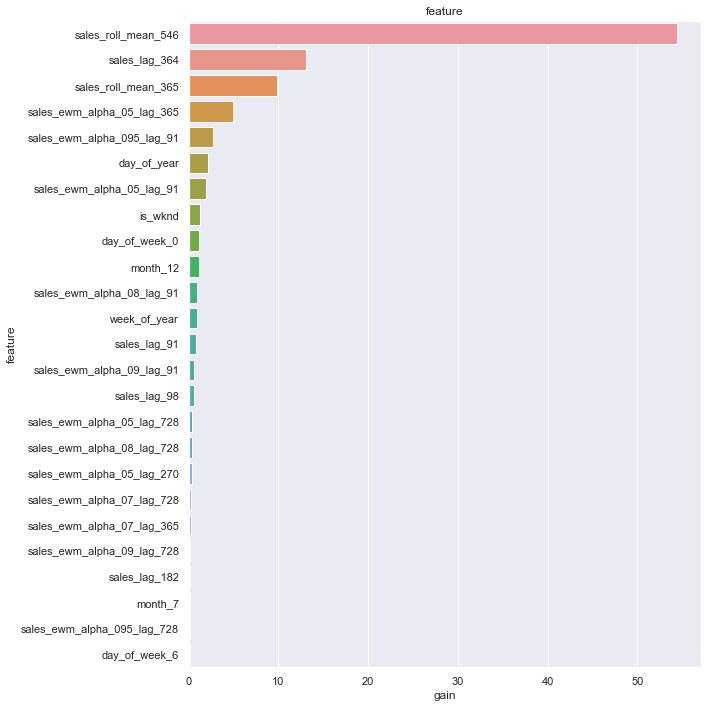

,feature,split,gain
17,sales_roll_mean_546,933,54.401173
13,sales_lag_364,1241,13.071469
16,sales_roll_mean_365,607,9.857533
60,sales_ewm_alpha_05_lag_365,380,4.989313
18,sales_ewm_alpha_095_lag_91,85,2.662891
...,...,...,...
111,item_39,0,0.000000
74,item_2,0,0.000000
86,item_14,0,0.000000
115,item_43,0,0.000000


In [34]:
plot_lgb_importances(model, num=30, plot=True)

In [35]:
# importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values
# imp_feats = [col for col in cols if col not in importance_zero]
# len(imp_feats)

In [36]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]


test = df.loc[df.sales.isna()]
X_test = test[cols]

In [37]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)


test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.433698 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [38]:
submission_df = test.loc[:, ["id", "sales"]]
submission_df['sales'] = np.expm1(test_preds)

submission_df['id'] = submission_df.id.astype(int)

submission_df.to_csv("submission.csv", index=False)